In [62]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer

In [63]:
df = pd.read_excel("Dataset.xlsx")
df.head()

,Query,Solution
0,আখের খোল পচে গেছে আখের নিচের পাতায় লাল লাল রঙ্...,1
1,আখের খোল নষ্ট হয়ে আখের পাতায় লাল লাল দাগ পড়েছে,1
2,আখের খোল পচে পাতা লাল হয়ে গেছে,1
3,আখের খোল পঁচা রোগ হয়েছে,1
4,আখের খোল পচে গেছে পাতায় লাল দাগ পড়েছে,1


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Query     1037 non-null   object
 1   Solution  1037 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.3+ KB


In [65]:
df['Solution'].value_counts()

32    54
31    44
1     40
43    40
46    36
45    34
53    32
47    31
2     30
35    28
26    26
48    26
12    26
42    26
14    26
10    24
11    24
37    24
49    24
34    22
6     22
36    22
52    22
39    18
38    18
7     18
44    18
25    18
13    18
16    16
41    16
29    14
30    14
5     14
50    14
24    12
40    10
4     10
51    10
28    10
3     10
33    10
9     10
19    10
8      8
23     8
22     8
21     8
18     8
27     8
20     6
17     6
15     6
Name: Solution, dtype: int64

In [66]:
tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

In [67]:
token = tokenizer.encode_plus(
    df['Query'].iloc[0],
    max_length = 256,
    truncation = True,
    padding = 'max_length',
    add_special_tokens = True,
    return_tensors='tf',
)

In [68]:
token

{'input_ids': <tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101, 18934, 34989,  4194, 23323,  2149, 18934,  4983,  4590,
         9294,  3167,  3167,  5983, 19447,  2984, 71923, 50831,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [69]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [70]:
X_input_ids.shape

(1037, 256)

In [71]:
def generate_training_data(df, ids, masks, tokenizer):
  for i, text in tqdm(enumerate(df['Query'])):
    tokenized_text = tokenizer.encode_plus(
        text,
        max_length = 256,
        truncation = True,
        padding = 'max_length',
        add_special_tokens = True,
        return_tensors='tf',
    )
    ids[i, :] = tokenized_text.input_ids
    masks[i, :] = tokenized_text.attention_mask
  return ids, masks
  


In [72]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

1037it [00:00, 1875.24it/s]


In [73]:
X_input_ids

array([[  101., 18934., 34989., ...,     0.,     0.,     0.],
       [  101., 18934., 34989., ...,     0.,     0.,     0.],
       [  101., 18934., 34989., ...,     0.,     0.,     0.],
       ...,
       [  101.,  4058.,  2395., ...,     0.,     0.,     0.],
       [  101.,  4058.,  2395., ...,     0.,     0.,     0.],
       [  101.,  4058.,  2395., ...,     0.,     0.,     0.]])

In [74]:
labels = np.zeros((len(df), 54))
labels.shape

(1037, 54)

In [75]:
labels[np.arange(len(df)), df['Solution'].values] = 1

In [76]:
labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [77]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))

In [78]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(54,), dtype=tf.float64, name=None))>

In [79]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
  return{
      'input_ids': input_ids,
      'attention_mask': attn_masks
  }, labels

In [80]:
dataset = dataset.map(SentimentDatasetMapFunction)

In [81]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(54,), dtype=tf.float64, name=None))>

In [82]:
dataset = dataset.shuffle(1000).batch(16, drop_remainder = True)

In [83]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=100):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [84]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [85]:
len(train_ds)

51

In [86]:
from transformers import TFBertModel

In [87]:
bert_model = TFBertModel.from_pretrained('sagorsarker/bangla-bert-base')

Some layers from the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at sagorsarker/bangla-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [88]:
input_ids = tf.keras.layers.Input(shape = (256, ), name = 'input_ids', dtype = 'int32')
attention_masks = tf.keras.layers.Input(shape = (256, ), name = 'attention_mask', dtype = 'int32')

In [89]:
bert_embds = bert_model.bert(input_ids, attention_mask = attention_masks)[1]

intermediate_layer = tf.keras.layers.Dense(128, activation = 'relu', name = 'intermediate_layer')(bert_embds)
intermediate_layer = tf.keras.layers.Dense(256, activation = 'relu', name = 'intermediate_layer')(bert_embds)
intermediate_layer = tf.keras.layers.Dense(512, activation = 'relu', name = 'intermediate_layer')(bert_embds)

output_layer = tf.keras.layers.Dense(54, activation = 'softmax', name = 'output_layer')(intermediate_layer)

model = tf.keras.Model(inputs = [input_ids, attention_masks], outputs = output_layer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  164396544   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

In [90]:
optim = tf.keras.optimizers.Adam(learning_rate = 1e-5, decay = 1e-6)

loss_func = tf.keras.losses.CategoricalCrossentropy()

acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [91]:
model.compile(optimizer = optim, loss = loss_func, metrics = [acc])

In [92]:
hist = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10
)

Epoch 1/10
51/51 [==============================] - 513s 10s/step - loss: 3.7516 - accuracy: 0.1029 - val_loss: 3.1863 - val_accuracy: 0.3542
Epoch 2/10
51/51 [==============================] - 434s 9s/step - loss: 3.0535 - accuracy: 0.3578 - val_loss: 2.4926 - val_accuracy: 0.5417
Epoch 3/10
51/51 [==============================] - 432s 8s/step - loss: 2.2749 - accuracy: 0.5735 - val_loss: 1.7240 - val_accuracy: 0.6979
Epoch 4/10
51/51 [==============================] - 406s 8s/step - loss: 1.5679 - accuracy: 0.7708 - val_loss: 0.8427 - val_accuracy: 0.8854
Epoch 5/10
51/51 [==============================] - 406s 8s/step - loss: 1.0568 - accuracy: 0.8603 - val_loss: 0.6797 - val_accuracy: 0.9167
Epoch 6/10
51/51 [==============================] - 407s 8s/step - loss: 0.7049 - accuracy: 0.9240 - val_loss: 0.3027 - val_accuracy: 0.9896
Epoch 7/10
51/51 [==============================] - 406s 8s/step - loss: 0.4952 - accuracy: 0.9583 - val_loss: 0.2611 - val_accuracy: 0.9583
Epoch 8/10
5

In [93]:
model.evaluate(test_ds)

7/7 [==============================] - 16s 2s/step - loss: 0.1220 - accuracy: 0.9732


[0.12199083715677261, 0.9732142686843872]

Text(0.5, 1.0, 'Training and validation loss')

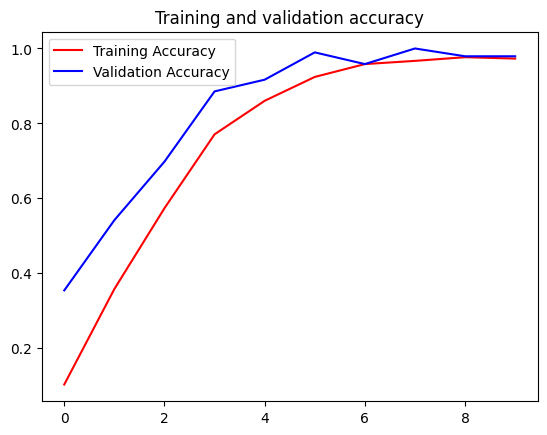

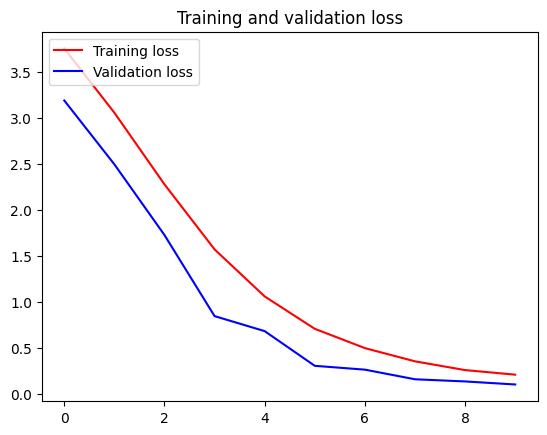

In [94]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt



acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


# Plot training and validation accuracy per epoch

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.figure()


# Plot training and validation loss per epoch

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation  Loss")
plt.legend(['Training loss', 'Validation loss'], loc='upper left')

plt.title('Training and validation loss')


In [95]:
model.save("models/test1.h5")

In [96]:
from tensorflow import keras
model = keras.models.load_model("models/test1.h5")
model

In [ ]:
scores = model.evaluate(test_ds)